# Connecting to Gen AI Models

## Introduction

ARTKIT model classes support connecting to Gen AI model APIs from various providers. This tutorial walks through the process of setting up various ARTKIT connectors to send requests and receive responses from popular Gen AI models. 

We currently support the following model connections:

- [OpenAI](https://openai.com/) - *Text, Image Generation, Vision*
- [Anthropic](https://www.anthropic.com/) - *Text only*
- [Groq](https://groq.com/) - *Text only*
- [Google's Gemini](https://gemini.google.com/?utm_source=google&utm_medium=cpc&utm_campaign=2024enUS_gemfeb&gad_source=1&gclid=Cj0KCQjwpNuyBhCuARIsANJqL9MyZ6ryxPne5jK3hH8f8rRi9ACTUcbroOcdrJB2OaiLR6yTGMMfozwaArcyEALw_wcB) - *Text only*
- [Hugging Face](https://huggingface.co/) - *Text only*

Key benefits of using ARTKIT model classes include: 

- **Built-in support for asynchronous requests**
    - Asynchronicity improves the performance of I/O bound tasks like API calls or file operations by allowing them to run concurrently without blocking the execution of other parts of your program.
    - *All* ARTKIT model classes are designed for asynchronicity. This design decision promotes asynchronous programming in ARTKIT pipelines and keeps our library minimalistic. 
    - ARTKIT pipelines are capable of handling synchronous steps and users are welcome to define custom synchronous API connectors. However, running ARTKIT synchronously negates the performance gains enabled by the underlying asynchronous computing engine. 
- **Chat history management**
    - Chat history management is essential for realistic multiturn interactions. Without chat history management, a chat model can only respond to the most recent request. 
    - ARTKIT chat model classes manage chat history in the background. See the [Multi-Turn Personas](../generating_challenges/multi_turn_personas.ipynb) tutorial for a demonstration of automated multiturn chats between a challenger bot and a target system.
    - Additionally, ARTKIT offers the `HistorizedChatModel` wrapper class which manages chat histories for any given `ChatModel`
- **Local cache management**
    - Caching Gen AI model responses is useful for ensuring reproducibility and avoiding repetitive API calls which can run up costs and runtime during development. 

For technical details on ARTKIT model classes and all supported models, see the [API Reference](../../apidoc/artkit.rst). If you need to connect to an endpoint which is not supported by ARTKIT, see our tutorial on [Creating New Model Classes](../advanced_tutorials/creating_new_model_classes.ipynb), and please consider [Contributing](../../contributor_guide/index.rst) to ARTKIT!

## Setup

To connect to different model providers, you must install the necessary platform-specific libraries:

```
pip install openai
pip install anthropic
pip install groq
pip install google-generativeai
pip install huggingface
```

You must obtain an API Key for each platform you plan to use. Platform-specific links are provided in the sections below. We recommend storing environment variables in a `.env` file within your project and loading them using `load_dotenv`, as shown below. For a step-by-step guide, see our documentation on [Environment Variables](../../_generated/home.rst#environment-variables). 

In [1]:
import artkit.api as ak

from dotenv import load_dotenv
load_dotenv();

> **Important**: The `await` keyword can normally only be used within an asynchronous function. In the codeblocks below, we are able to use `await` on its own because Jupyter notebooks implicitly execute cells asynchronously. If running code in a Python script, you must use ARTKIT connectors within the context of asynchonous functions, as demonstrated throughout the documentation (e.g., [Building Your First ARTKIT Pipeline](building_your_first_artkit_pipeline.ipynb))

## OpenAI

To make API calls to OpenAI, you must install the `openai` Python library and obtain an [OpenAI API key](https://platform.openai.com/docs/quickstart/account-setup).

ARTKIT connectors currently support three types of OpenAI models:

1. Chat (LLMs)
2. Text-to-image (diffusion models)
3. Image-to-text (vision models)

Below we show how to instantiate each OpenAI model class with caching, send a request, and view the response.

### Chat

Chat models are used to emulate a conversation between a user and language model by utilizing it's text completion capabilities.
The `OpenAIChat` class returns an ARTKIT list of strings, which are probable candidates for a conversational reply given the prompt.

In [2]:
# Initialize an OpenAI chat model
openai_chat_model = ak.CachedChatModel(
    model = ak.OpenAIChat(
        api_key_env="OPENAI_API_KEY",
        model_id="gpt-3.5-turbo",
        system_prompt=None,
        temperature=1,
        seed=0,
        ),
    database="cache/connecting_to_openai_gpt3-5.db"
)


# Send a message to the chat model and print the response
response = await openai_chat_model.get_response(message="What is 2+2?")
print(response[0])

2 + 2 equals 4.


### Text-to-Image

The `OpenAIDiffusion` class returns an ARTKIT `Image` object, which has a `show` method for visualizing images.

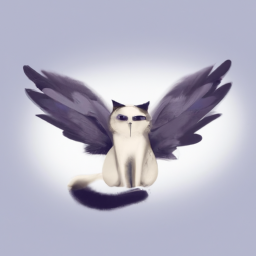

In [3]:
# Initialize an OpenAI diffusion model
openai_diffusion_model = ak.CachedDiffusionModel(
    model = ak.OpenAIDiffusion(
        api_key_env = "OPENAI_API_KEY",
        model_id = "dall-e-2",
        size = "256x256",
    ),
    database="cache/connecting_to_openai_dalle.db"
)


# Send text to the diffusion model and display the image response
winged_cat = await openai_diffusion_model.text_to_image(text="a cat with wings")

winged_cat[0].show(width=200)

### Vision

Here, we use ARTKIT's `OpenAIVision` class to send an image and a prompt to GPT-4-turbo, which recently enabled image inputs through the API:

In [4]:
# Initialize an OpenAI vision model
openai_vision_model = ak.CachedVisionModel(
    model=ak.OpenAIVision(
        api_key_env="OPENAI_API_KEY",
        model_id='gpt-4-turbo'
    ),
    database="cache/connecting_to_openai_gpt4v.db"
)


# Send an image and a prompt to the vision model and print the response
response = await openai_vision_model.image_to_text(
    image=winged_cat[0], 
    prompt="What is this, in 10 words?")

print(response[0])

Mythical winged cat, serene expression, feathers, tail, artistic creature portrayal.


## Anthropic

[Anthropic](https://www.anthropic.com/) is an AI research company that prioritizes ethics and social impact in their products and services. To interact with the Anthropic API, [register](https://console.anthropic.com/) an account with Anthropic and generate an API key in your [Account Settings](https://console.anthropic.com/account/keys). You must also install the `anthropic` Python library. Visit [Anthropic Models](https://docs.anthropic.com/en/docs/models-overview) for a list of available models.

Just as with the OpenAI example ARTKIT offers an `AnthropicChat` class that returns a list of possible responses in string format. Below we show how to instantiate and use an Anthropic chat model:

In [5]:
# Initialize an Anthropic chat model
anthropic_chat_model = ak.CachedChatModel(
    model=ak.AnthropicChat(
        api_key_env="ANTHROPIC_API_KEY",
        model_id="claude-3-sonnet-20240229",
        max_tokens=100,
    ),
    database="cache/connecting_to_anthropic_chat.db"
)


# Send a message to the chat model and print the response
response = await anthropic_chat_model.get_response(message="What is 2+2?")

print(response[0])

2 + 2 = 4


## Groq

[Groq](https://wow.groq.com/why-groq/) is a Gen AI hardware and software platform that prioritizes inference speed. To make API calls to Groq, register an account and create your API key in your [GroqCloud console](https://console.groq.com/keys). Groq currently hosts a few popular Gen AI models, including LLaMA3, Mixtral, Gemma, and Whisper. Visit [Groq Models](https://console.groq.com/docs/models) for the models you can use with Groq.

Below we show how to instantiate a Groq chat model to interact with LLaMA-8b:

In [6]:
# Initialize a Groq chat model
groq_chat_model = ak.CachedChatModel(
    model=ak.GroqChat(
        api_key_env="GROQ_API_KEY",
        model_id="llama3-8b-8192",
    ),
    database="cache/connecting_to_groq_chat.db"
)

# Send a message to the chat model and print the response
response = await groq_chat_model.get_response(message="What is 2 + 2")

print(response[0])

The answer to 2 + 2 is 4.


## Google

[Gemini](https://gemini.google.com/?utm_source=google&utm_medium=cpc&utm_campaign=2024enUS_gemfeb&gad_source=1&gclid=Cj0KCQjwpNuyBhCuARIsANJqL9MyZ6ryxPne5jK3hH8f8rRi9ACTUcbroOcdrJB2OaiLR6yTGMMfozwaArcyEALw_wcB) is a family of multimodal Gen AI models available through Vertex AI, Google's fully-managed AI development platform for building and using Gen AI. To interact with the Gemini API, install the Python library `google-generativeai` and generate a [Gemini API key](https://ai.google.dev/gemini-api/docs/api-key). For a list of currently available Gemini models, visit [Gemini Models](https://ai.google.dev/gemini-api/docs/models/gemini).

Below we show how to instantiate a Gemini model class to interact with the Gemini API:

In [7]:
# Initialize a Gemini chat model
gemini_chat_model = ak.CachedChatModel(
    model=ak.GeminiChat(
        api_key_env="GEMINI_API_KEY",
        model_id="gemini-1.5-pro-latest",
    ),
    database="cache/connecting_to_gemini_chat.db"
)


# Send a message to the chat model and print the response
response = await gemini_chat_model.get_response(message="What is 2 + 2?")

print(response[0])

2 + 2 = 4 



## Hugging Face

[Hugging Face](https://huggingface.co/) is a popular platform for hosting open source models, datasets, and code. To make API calls to HuggingFace, you must first register an account with Hugging Face and create a [Hugging Face API key](https://huggingface.co/settings/tokens) in your profile settings. You must also install the `huggingface` Python library.

Given the diversity of models hosted on Hugging Face, it is important to read the documentation for individual models to understand the expected input and output formats, model-specific parameters, limitations, and best practices. See [Hugging Face Models](https://huggingface.co/models?sort=trending&search=huggingface) to browse the models available on Hugging Face. 

Note that some models require you to request access by visiting the model's repository site. Gated or private models require running the following:

In [8]:
# Needed to access gated or private models on the Hugging Face Hub
from huggingface_hub import login
login()

### Chat templates

A key concept for working with Hugging Face models is [chat templates](https://huggingface.co/docs/transformers/main/chat_templating), which specify how to convert conversation histories into a format which works for a specific model. A conversation history is comprised of a list of messages, where each message is a dictionary containing `role` and `content` keys. For example:

In [9]:
messages = [
    {"role": "system", 
     "content": "You are a friendly assistant."},
    {"role": "user", 
     "content": "What is 2+2?"},
    {"role": "assistant", 
     "content": "2 + 2 = 4"},
    {"role": "user", 
     "content": "Looks correct, thanks."},
 ]

Individual LLMs are trained to recognize chat histories in a particular format. The Hugging Face [standard for chat templates](https://huggingface.co/docs/transformers/main/en/chat_templating#advanced-how-do-chat-templates-work) is to represent them as [Jinja templates](https://jinja.palletsprojects.com/en/3.1.x/templates/), which look like this:

```
{% for message in messages %}
    {% if message['role'] == 'user' %}
        {{ ' ' }}
    {% endif %}
    {{ message['content'] }}
    {% if not loop.last %}
        {{ '  ' }}
    {% endif %}
{% endfor %}
{{ eos_token }}
```

There are two types of Hugging Face models: 

1. **Models with native chat templates**:
    - The chat template will be specified as the `chat_template` parameter inside the model's `tokenizer_config.json` file. 
    - For example, the chat template for the `zephyr-7b-beta` model can be found [here](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta/blob/main/tokenizer_config.json#L34).
2. **Models with empty chat templates**:
    - For many models on Hugging Face, the `chat_template` parameter in the `tokenizer_config.json` file is empty.
    - Usually, the chat template can be found elsewhere in the documentation, e.g., on the model card page.
    - However, if you're unable to find any chat template, make sure that the model you're trying to use is actually trained for chat applications

Below, we show how to work with both types of models. We'll start with the first option, as it is the easiest:

### Native chat templates

We'll demonstrate usage of a native chat template using the `zephyr-7b-beta` model referenced above. The fact that the chat template is specified [here](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta/blob/main/tokenizer_config.json#L34) in the `tokenizer_config.json` allows us to set up a Hugging Face connector like this:

In [10]:
hf_chat_native = ak.HuggingfaceChat(
    model_id="HuggingFaceH4/zephyr-7b-beta", 
    api_key_env="HF_TOKEN",
    chat_template_params={"add_generation_prompt": True}
)

Note the usage of the `add_generation_prompt` argument. The [generation prompt](https://huggingface.co/docs/transformers/main/en/chat_templating#what-are-generation-prompts) argument adds a token to the end of each message to indicate that the bot should start its response. This helps ensure the model generates the next response in the conversation, which is useful for conversational applications of LLMs.

Now let's get a response from the model:

In [11]:
response = await hf_chat_native.get_response("What is 2 + 2?")

print(response[0])

/Users/lontkealexander/.pyenv/versions/rai_red/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


4 is the answer to the mathematical expression "2 + 2". This is a basic arithmetic operation called addition, where you add two numbers (2 in this case) to get a sum (4).


This approach works for models that have a chat template defined in their `tokenizer_config.json` file, but what if the chat template parameter is empty? That's when custom chat templates are needed.

### Custom chat templates

For models without a chat template specified in the `tokenizer_config.json` file, it is essential to determine the expected template from another source. If you cannot find and specify a correct chat template, then the model is likely to return unexpected and unpredictable responses.

We saw in the previous section that the `zephyr-7b` model has a native template defined, so we don't need to specify a custom template. However, for illustrative purposes, we will define and use a custom chat template for `zephyr-7b` using the ARTKIT `HuggingfaceChat` connector and confirm that it produces the same output as the native template approach. 

Here is the `zephyr-7b` chat template defined as a Python string:

In [12]:
zephyr_template = (
    "{% for message in messages %}\n{% if message['role'] == 'user' %}\n"
    "{{ '<|user|>\n' + message['content'] + eos_token }}\n"
    "{% elif message['role'] == 'system' %}\n"
    "{{ '<|system|>\n' + message['content'] + eos_token }}\n"
    "{% elif message['role'] == 'assistant' %}\n"
    "{{ '<|assistant|>\n'  + message['content'] + eos_token }}\n"
    "{% endif %}\n"
    "{% if loop.last and add_generation_prompt %}\n"
    "{{ '<|assistant|>' }}\n"
    "{% endif %}\n"
    "{% endfor %}"
)

Now, we pass the Jinja template to the `chat_template` argument when we set up our `HuggingfaceChat` connector. Note that this argument was not used in the previous section because we used the native template. When we execute this code, ARTKIT will show a warning alerting us that we are overriding the native chat template with our custom template:

In [13]:
hf_chat_custom = ak.HuggingfaceChat(
    model_id="HuggingFaceH4/zephyr-7b-beta", 
    api_key_env="HF_TOKEN",
    chat_template=zephyr_template,
    chat_template_params={"add_generation_prompt": True}
)

Now let's get a response from the model. Since our custom chat template is identical to the native template for `zephyr-7b`, the response should be identical:

In [14]:
response = await hf_chat_custom.get_response("What is 2 + 2?")

print(response[0])

Tokenizer (HuggingFaceH4/zephyr-7b-beta) natively supports chat templates, but will be overridden by the given custom chat template.


4 is the answer to the mathematical expression "2 + 2". This is a basic arithmetic operation called addition, where you add two numbers (2 in this case) to get a sum (4).


Looks like it worked! 

Chat templates are one of the more challenging aspects of working with Hugging Face models, but understanding how they work and using them correctly is necessary for anyone who wishes to tap into the vast Gen AI model landscape available on Hugging Face.

## Concluding Remarks

We hope this tutorial helps ARTKIT users to leverage our asynchronous model connectors with confidence. We aim to keep this notebook updated with the latest ARTKIT model classes, but please note that the [API Reference](../../apidoc/artkit.rst) always contains the most comprehensive list of connectors and capabilities. 

If you find any bugs or feature limitations, please [open an issue](../../contributor_guide/how_to_contribute.rst#general-git-process) and we will follow up as soon as possible. If you need to a connector which is not supported by ARTKIT, our tutorial on [Creating New Model Classes](../advanced_tutorials/creating_new_model_classes.ipynb) provides guidance on how to build a custom connector class. If you create a connector which is likely to be useful for others, consider [Contributing](../../contributor_guide/index.rst) to ARTKIT!